# Implementing the Tausworthe Generator

## Project Topic Description:

The project aims to:

- Implement a Tausworthe PRN generator

- Plot adjacent PRNs to check for patterns in the generated uniforms

- Perform the chi-squared goodness of fit test, the 'above and below mean' test, and the autocorrelation test to check if the generated uniforms are i.i.d

- Generate Nor(0,1) random deviates from the PRNs


This project is presented as a Python Notebook since it is a purely implementation based project. All relevant statistical test results and figures can also be found in the results folder inside the code zip folder. 

Let's begin by defining the Tausworthe generator class as shown below. It's primary functions are to add bits to the initially defined bits, split bits by a user-defined value $l$, and generate the uniform random numbers corresponding to the selected $l_i$ bits over the range TotalBits / $l$. Each random number is then computed to be $l_i$ bits / $2^l$. Since $B_i = (B_{i-r} + B_{i-q}) % 2$, we can write this as $B_i = B_{i-r} (XOR) B_{i-q}$. Since we are doing a bit-wise XOR operation, we can simply define the truth table of the XOR operation in the static method shown below.

In [1]:
# Tauseworthe generator class - CELL 1
class tauseworthe:

    def __init__(self, bits, r, q):
        self.bits = bits
        self.r = r
        self.q = q

    # String-based XOR implementation
    @staticmethod
    def XOR(a,b):
        assert(a == '0' or a == '1')
        assert(b == '0' or b == '1')

        # Simple definition of the truth table with bits taken as string inputs
        if ((a == '0' and b == '0') or ((a == '1' and b == '1'))):
            return '0'

        if ((a == '1' and b == '0') or ((a == '0' and b == '1'))):
            return '1'

    # Generating the next subsequent bit by XOR'ing 2 bits whose indices are determined by r and q
    def add_bit(self):
        assert(self.r > 0)
        assert(self.q > self.r)
        last_ind = len(self.bits) - 1
        next_bit = tauseworthe.XOR(self.bits[last_ind - self.r], self.bits[last_ind - self.q])
        

        self.bits += next_bit
        

    # Splitting the bits into groups of 'l'
    def split_bits(self, l):
        bit_list = [self.bits[i:i+l] for i in range(0, len(self.bits), l)]
        return bit_list
        
    # Generating uniforms    
    def rdm_unif(self, bit_list):
        unif_list = []
        denom = 2**len(bit_list[0])
        for bits in bit_list:
            int_rep = int(bits,2)/denom
            unif_list.append(int_rep)
        return unif_list

We now define a function to plot adjacent pseudo random numbers.

In [2]:
# Function to plot pseudo random numbers - CELL 2
import matplotlib.pyplot as plt
import numpy as np
def plot_prns(prn_list):
    x_pts = []
    adj_pts = []
    for i in range(len(prn_list)-1):
        x_pts.append(prn_list[i])
        adj_pts.append(prn_list[i+1])
        
    plt.scatter(x_pts, adj_pts)
    plt.show()

100%|██████████| 100000/100000 [00:00<00:00, 431035.16it/s]


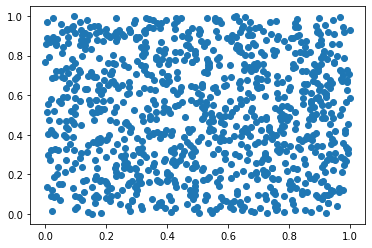

In [3]:
# Tauseworth implementation - CELL 3
from tqdm import tqdm
t1 = tauseworthe('100011010001010101111101010011001101010111 \
                 1101011101011101101011101010001001010101010101', r = 15, q = 30)
for i in tqdm(range(100000)):
    t1.add_bit()
k = t1.split_bits(l = 101)
rdm_unif_list = t1.rdm_unif(k)
plot_prns(rdm_unif_list)

The graph above consists of about 1000 points. It seems unlikely that there is any inherent pattern in the graph above. The value of 'q' is large enough to ensure a good cycle period.

To perform the hypothesis tests, we begin by generating 10,000 PRNs as shown below. The initial bits are randomly initialized along with r = 15 and q = 30.

In [4]:
# Tauseworth implementation for 10,000 uniform random numbers - CELL 4
from tqdm import tqdm
t1 = tauseworthe('100011010001010101111101010011001101010111\
                    1101011101011101101011101010001001010101010101', r = 15, q = 30)
for i in tqdm(range(1000000)):
    t1.add_bit()
k = t1.split_bits(l = 101)
rdm_unif_list = t1.rdm_unif(k)

100%|██████████| 1000000/1000000 [00:18<00:00, 55406.27it/s]


## Tests to Establish that the PRNs are IID

### Chi-Squared Goodness of Fit test to check if PRNs are identically distributed

In [5]:
# Chi-square goodness of fit test - CELL 5

from scipy.stats import norm
from scipy.stats import chi2

def gof_test(k, unif_list, alpha):
    intervals = []
    for i in range(k):
        req_tup = (i/k, (i+1)/k)
        intervals.append(req_tup)
    print("Intervals:")
    print(intervals)

    E_i = len(unif_list)/k
    print("Value of expected number of elements in each bin:")
    print(E_i)
    print()
    k_dict = dict()

    # Initialize counts
    for i in range(k):
        k_dict[i] = 0

    for num in unif_list:        
        for i,ele in enumerate(intervals):
            if (num >= ele[0] and num < ele[1]):
                k_dict[i] += 1

    bin_list = []
    for b in k_dict:
        bin_list.append(k_dict[b])

    print(bin_list)
    print()
    chi_2 = 0
    
    # Getting the value for the test statistic
    for ele in bin_list:
        chi_2 += ((ele - E_i)**2)/E_i

    print("Computed chi-squared test statistic = {}".format(chi_2))
    
    # Getting the value for the quantile
    chi_lim = chi2.ppf(1-alpha, k-1)
    print("Chi_square quantile at 1-alpha level = {}" .format(chi_lim))
    
    # Deciding whether to reject the null or not
    if chi_2 > chi_lim:
        print("Null rejected")
    
    else:
        print("Failed to reject null")

In [6]:
# Running the goodness of fit test - CELL 6
gof_test(5, rdm_unif_list, alpha = 0.05)

Intervals:
[(0.0, 0.2), (0.2, 0.4), (0.4, 0.6), (0.6, 0.8), (0.8, 1.0)]
Value of expected number of elements in each bin:
1980.4

[1998, 1935, 2045, 1959, 1965]

Computed chi-squared test statistic = 3.655423146839022
Chi_square quantile at 1-alpha level = 9.487729036781154
Failed to reject null


As seen from the results above, the null cannot be rejected at an $\alpha$ level of 0.05.

### Above and below the mean test for independence

In [7]:
# Above and below mean test - CELL 7
def above_below(unif_list, alpha):
    signs = []
    above = 0
    below = 0
    for ele in unif_list:
        if ele >= 0.5:
            signs.append('+')
            above += 1
        else:
            signs.append('-')
            below += 1
    runs = 1
    for i in range(len(signs) - 2):
        if signs[i] != signs[i+1]:
            runs += 1
    

    mu = ((2*above*below)/len(unif_list)) + 0.5
    var = (2*above*below*(2*above*below - len(unif_list)))/((len(unif_list) - 1)*len(unif_list)**2)

    z_0 = (runs - mu) / np.sqrt(var)

    if np.abs(z_0) < norm.ppf(1 - alpha/2):
        print("Failed to reject independence hypothesis")

    else:
        print("Rejected independence hypothesis")
    
    print("Number of runs = {}".format(runs))
    print("Computed test statistic value = {}".format(np.abs(z_0)))
    print("Threshold at level 1 - alpha/2 = {}".format(norm.ppf(1 - alpha/2)))

above_below(rdm_unif_list, 0.05)

Failed to reject independence hypothesis
Number of runs = 5015
Computed test statistic value = 1.2768311034257445
Threshold at level 1 - alpha/2 = 1.959963984540054


Again, as seen above, we fail to reject the null (independence hypothesis).

### Autocorrelation test for independence

In [8]:
# Autocorrelation test for independence - CELL 8
def autocorr_test(unif_list, alpha):
    n = len(unif_list)
    temp = 0
    
    for i in range(n-2):
        temp += unif_list[i]*unif_list[i+1]

    ro = ((12/(n-1))*temp) - 3 
    var = (13*n - 19)/((n-1)**2)

    z_0 = ro/np.sqrt(var)

    if np.abs(z_0) < norm.ppf(1 - alpha/2):
        print("Failed to reject independence hypothesis")

    else:
        print("Rejected independence hypothesis")
    
    print("Value of ro_hat = {}".format(ro))
    print("Computed test statistic value = {}".format(np.abs(z_0)))
    print("Threshold at level 1 - alpha/2 = {}".format(norm.ppf(1 - alpha/2)))

autocorr_test(rdm_unif_list, 0.05)

Failed to reject independence hypothesis
Value of ro_hat = -0.0029072252344923832
Computed test statistic value = 0.08023366971571375
Threshold at level 1 - alpha/2 = 1.959963984540054


### Generating Nor(0,1) deviates from the PRNs

From IVT, we can take the inverse Normal CDF with the PRN values in order to get a set of Normal RVs. PLEASE NOTE : The norm.ppf function is only being used here to get the inverse CDF. The random variates for the normal are still being generated from the uniforms of the Tauseworth Generator. The plot below looks fairly like a Nor(0,1) distribution centered correctly about 0.

<AxesSubplot:ylabel='Count'>

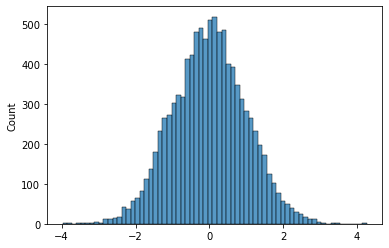

In [9]:
# Generating normally distributed random variables - CELL 9

import seaborn as sns

norm_variates = []
for ele in rdm_unif_list:
    norm_variates.append(norm.ppf(ele))

sns.histplot(norm_variates)